# 1. Methods – simulation study

Explainable Boosting Machines (EBMs) offer several valuable properties: they are transparent glass-box models and include a built-in interpretability framework. Although their predictive performance is typically comparable to other tree-based models such as Random Forest and XGBoost, we verify this claim in our context by evaluating multiple models (with default hyperparameters) and comparing their RMSE. We then assess the quality of different uncertainty estimates using two standard metrics: coverage and sharpness.

**Simulation studies** allow us to obtain empirical results on the performance of statistical methods under controlled scenarios. In our study, we vary:
- **Data split seeds** (train & calibration, and optionally test): vary to capture variability from different sample selections.
- _Not_ the model seeds (initialization, dropout, shuffling, etc.): if fixed, they should be repeated only when the model is highly stochastic.

In practice, the main source of uncertainty comes from which samples fall into train/calibration/test sets, and not model initialization. Repeating data resampling provides: 1) a distribution for evaluation metrics, 2) reliable confidence intervals, and 3) paired statistical tests that reduce variance in model comparisons.

🔗 **Resources**: https://pmc.ncbi.nlm.nih.gov/articles/PMC6492164/

In [1]:
import sys
import os
from pathlib import Path
from tqdm import tqdm

import pandas as pd
import numpy as np
from scipy.stats import norm

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, BoundaryNorm

# Data
from sklearn.datasets import load_diabetes, fetch_california_housing

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from sklearn.model_selection import GridSearchCV

# Models
from interpret.glassbox import ExplainableBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
#from quantile_forest import RandomForestQuantileRegressor
#from lightgbm import LGBMRegressor

import inspect

import ipywidgets as widgets
from IPython.display import display

In [2]:
sys.path.append(os.path.abspath(".."))
from src import (
    get_data_sample, evaluate_intervals, methods_simulation_study
)

## 1. Data

In [3]:
df_california = fetch_california_housing(as_frame=True)
df_diabetes = load_diabetes(as_frame=True)

In [4]:
df_sel = widgets.Dropdown(
    options=['California housing', 'Diabetes'],
    value='California housing',
    description='Choose a dataset:',
    style={'description_width': '150px'},
    layout=widgets.Layout(width='300px')
)

display(df_sel)

Dropdown(description='Choose a dataset:', layout=Layout(width='300px'), options=('California housing', 'Diabet…

In [5]:
if df_sel.value == 'California housing':
    X = pd.DataFrame(df_california.data, columns=df_california.feature_names)
    y = df_california.target
    n = len(y)
else:
    X = pd.DataFrame(df_diabetes.data, columns=df_diabetes.feature_names)
    y = df_diabetes.target
    n = len(y)

**Strategies for sampling data:**

**Strategy 1: Fixed Test, Resample Train/Calibration**

- Split once to get fixed_test (e.g., 20–30% of data).
- From the remaining pool, run n_reps repetitions: resample train vs calibration (keeping test fixed).
- For each repetition: train model on train, calibrate on calib, evaluate on fixed test.
- Aggregate metrics (mean, std, quantiles). Report final metric on the fixed test and show variance from resampling.

_Advantages:_

- Ensures fair comparison between models: test data is the same for all methods.
- Allows uncertainty estimation from repeated training/calibration splits.
- Reduces variability in final evaluation due to test set randomness.

**Strategy 2: Random Everything**

- Randomly split train, calibration, and test sets in every repetition.
- Train, calibrate, and evaluate on the corresponding sets.
- Aggregate metrics across repetitions.

In [6]:
#get_data_sample??
#get_data_sample(X=X, y=y, seed=42, train_size=0.6, calib_size=0.2, fixed_test=True)

In [7]:
# Check
seed_tmp = 42
train_size_tmp = 0.6
calib_size_tmp = 0.2

data_tmp = get_data_sample(X, y, train_size=train_size_tmp, calib_size=calib_size_tmp, seed=seed_tmp, fixed_test=True)

x_train_tmp = data_tmp.X_train
x_calib_tmp = data_tmp.X_calib
x_test_tmp = data_tmp.X_test

print(x_train_tmp.shape[0]/n, x_calib_tmp.shape[0]/n, x_test_tmp.shape[0]/n)

0.599951550387597 0.2000484496124031 0.2


## 2. Simulation study

### 2.1 Preliminary test 
(run a small experiment)

In [8]:
interval_methods_test = {
    ExplainableBoostingRegressor: ["conformal", "pi", "built-in"],
    RandomForestRegressor: ["conformal", "pi"],
    XGBRegressor: ["conformal", "pi"]
}

results = methods_simulation_study(
    dataset=df_california,
    model_class=ExplainableBoostingRegressor, 
    interval_methods=interval_methods_test,
    n_iter=5, 
    fixed_test=True
)

Simulation Progress: 100%|████████████████████████| 5/5 [01:07<00:00, 13.57s/it]


In [9]:
check_test_indeces = results['check_df_test']
all(l == check_test_indeces[0] for l in check_test_indeces)

True

In [10]:
results['rmse']
df_model_metrics = pd.DataFrame(results['rmse'])
df_model_metrics

,seed_0,seed_1,seed_2,seed_3,seed_4
train,0.415457,0.413862,0.414654,0.410224,0.423089
test,0.481262,0.476281,0.479547,0.478743,0.480673


In [11]:
df_conf_metrics = pd.DataFrame(results['conf_metrics'])
df_conf_metrics

,seed_0,seed_1,seed_2,seed_3,seed_4
coverage,0.945010,0.951308,0.949370,0.949128,0.950339
sharpness,1.912908,1.978089,1.948983,1.972099,2.010629


In [12]:
df_pi_metrics = pd.DataFrame(results['pi_metrics'])
df_pi_metrics

,seed_0,seed_1,seed_2,seed_3,seed_4
coverage,0.921754,0.924903,0.920785,0.922481,0.922965
sharpness,1.628626,1.622377,1.625480,1.608112,1.658546


In [13]:
df_bi_metrics = pd.DataFrame(results['bi_metrics'])
df_bi_metrics

,seed_0,seed_1,seed_2,seed_3,seed_4
coverage,0.260659,0.281977,0.261143,0.281008,0.268411
sharpness,0.244283,0.246018,0.251573,0.257401,0.255505


### 2.2 Full run
Run for each model (3) and dataset (2): in total we have 6 runs; for each we save 6 result files: **36 files in total**.

In [14]:
run_all = True # <------ Change for run!
n_iter = 200
output_folder_path = '../data/output/methods_sim_study/'

dfs = {'diabetes': df_diabetes, 'california': df_california}
models = {
    'rf': RandomForestRegressor,
    'ebm': ExplainableBoostingRegressor,
    'xgb': XGBRegressor
}

interval_methods = {
    RandomForestRegressor: ["conformal", "pi"],
    ExplainableBoostingRegressor: ["conformal", "pi", "built-in"],
    XGBRegressor: ["conformal", "pi"]
}

if run_all:
    for model_name, model in models.items():
        print(f'\n####')
        print(f'Starting simulation study for model: {model_name}')
        print(f'####')
        for df_name, df in dfs.items():
            print(f'Starting simulation study for df: {df_name}')
            print(df.frame.shape)
            sim_results = methods_simulation_study(
                dataset=df,
                model_class=model, 
                interval_methods=interval_methods,
                n_iter=n_iter, 
                fixed_test=True
            )
            # SAVING
            # model performance: rmse
            df_rmse_out = pd.DataFrame(sim_results['rmse']).T.reset_index().rename(columns={'index': 'seed'})
            file_name = f'rmse_{model_name}_{df_name}.csv'
            print(f'Saving file: {file_name}, with dimension {df_rmse_out.shape}')
            df_rmse_out.to_csv(output_folder_path + file_name, index=False)
            # standard PI
            if "pi" in interval_methods.get(model, []):
                df_pi_out = pd.DataFrame(sim_results['pi_metrics']).T.reset_index().rename(columns={'index': 'seed'})
                file_name = f'standard_pi_{model_name}_{df_name}.csv'
                print(f'Saving file: {file_name}, with dimension {df_pi_out.shape}')
                df_pi_out.to_csv(output_folder_path + file_name, index=False)
            # built in
            if "built-in" in interval_methods.get(model, []):
                df_bi_out = pd.DataFrame(sim_results['bi_metrics']).T.reset_index().rename(columns={'index': 'seed'})
                file_name = f'built_in_{model_name}_{df_name}.csv'
                print(f'Saving file: {file_name}, with dimension {df_bi_out.shape}')
                df_bi_out.to_csv(output_folder_path + file_name, index=False)
            # conformal
            if "conformal" in interval_methods.get(model, []):
                df_conf_out = pd.DataFrame(sim_results['conf_metrics']).T.reset_index().rename(columns={'index': 'seed'})
                file_name = f'conformal_{model_name}_{df_name}.csv'
                print(f'Saving file: {file_name}, with dimension {df_conf_out.shape}')
                df_conf_out.to_csv(output_folder_path + file_name, index=False)


####
Starting simulation study for model: rf
####
Starting simulation study for df: diabetes
(442, 11)


Simulation Progress: 100%|████████████████████| 200/200 [00:15<00:00, 13.12it/s]


Saving file: rmse_rf_diabetes.csv, with dimension (200, 3)
Saving file: standard_pi_rf_diabetes.csv, with dimension (200, 3)
Saving file: conformal_rf_diabetes.csv, with dimension (200, 3)
Starting simulation study for df: california
(20640, 9)


Simulation Progress: 100%|████████████████████| 200/200 [15:34<00:00,  4.67s/it]


Saving file: rmse_rf_california.csv, with dimension (200, 3)
Saving file: standard_pi_rf_california.csv, with dimension (200, 3)
Saving file: conformal_rf_california.csv, with dimension (200, 3)

####
Starting simulation study for model: ebm
####
Starting simulation study for df: diabetes
(442, 11)


Simulation Progress: 100%|████████████████████| 200/200 [02:57<00:00,  1.13it/s]


Saving file: rmse_ebm_diabetes.csv, with dimension (200, 3)
Saving file: standard_pi_ebm_diabetes.csv, with dimension (200, 3)
Saving file: built_in_ebm_diabetes.csv, with dimension (200, 3)
Saving file: conformal_ebm_diabetes.csv, with dimension (200, 3)
Starting simulation study for df: california
(20640, 9)


Simulation Progress: 100%|████████████████████| 200/200 [48:57<00:00, 14.69s/it]


Saving file: rmse_ebm_california.csv, with dimension (200, 3)
Saving file: standard_pi_ebm_california.csv, with dimension (200, 3)
Saving file: built_in_ebm_california.csv, with dimension (200, 3)
Saving file: conformal_ebm_california.csv, with dimension (200, 3)

####
Starting simulation study for model: xgb
####
Starting simulation study for df: diabetes
(442, 11)


Simulation Progress: 100%|████████████████████| 200/200 [00:04<00:00, 40.55it/s]


Saving file: rmse_xgb_diabetes.csv, with dimension (200, 3)
Saving file: standard_pi_xgb_diabetes.csv, with dimension (200, 3)
Saving file: conformal_xgb_diabetes.csv, with dimension (200, 3)
Starting simulation study for df: california
(20640, 9)


Simulation Progress: 100%|████████████████████| 200/200 [00:17<00:00, 11.21it/s]

Saving file: rmse_xgb_california.csv, with dimension (200, 3)
Saving file: standard_pi_xgb_california.csv, with dimension (200, 3)
Saving file: conformal_xgb_california.csv, with dimension (200, 3)


## 3. Results

### 3.1 Data preparation

In [34]:
files = []
for df_val in ['california', 'diabetes']:
    for model_abb in ["ebm", "rf", "xgb"]:
        for method in ['conformal', 'standard_pi', 'built_in', 'rmse']:
            for file in Path(output_folder_path).glob(f"{method}_{model_abb}_{df_val}.csv"):
                df_tmp = pd.read_csv(file) # Read csv into a DataFrame
                # print(f'Open {file} with shape {df_tmp.shape}')
                df_tmp['df'] = df_val
                df_tmp['model'] = model_abb
                uncertainty_method = file.stem.split(f"_{model_abb}_{df_val}")[0] # Extract text 
                df_tmp['uncertainty_method'] = uncertainty_method
                files.append(df_tmp) # Collect DataFrames

In [35]:
# Access to a single file
# pd.read_csv(output_folder_path + 'rmse_ebm_california.csv').head()

In [38]:
df_all = pd.concat(files)
df_all = df_all.rename(columns={'uncertainty_method': 'metric'})
df_all.metric.value_counts()

metric
conformal      1200
standard_pi    1200
rmse           1200
built_in        400
Name: count, dtype: int64

In [39]:
df_california_results = df_all[df_all['df']=='california']
df_diabetes_results = df_all[df_all['df']=='diabetes']
# df_diabetes_results

df_california_results

# Note: the columns train and test are populated only when the metric is rmse

,seed,coverage,sharpness,df,model,metric,train,test
0,seed_0,0.945010,1.912908,california,ebm,conformal,NaN,NaN
1,seed_1,0.951308,1.978089,california,ebm,conformal,NaN,NaN
2,seed_2,0.949370,1.948983,california,ebm,conformal,NaN,NaN
3,seed_3,0.949128,1.972099,california,ebm,conformal,NaN,NaN
4,seed_4,0.950339,2.010629,california,ebm,conformal,NaN,NaN
...,...,...,...,...,...,...,...,...
195,seed_195,NaN,NaN,california,xgb,rmse,0.246597,0.471944
196,seed_196,NaN,NaN,california,xgb,rmse,0.248671,0.469470
197,seed_197,NaN,NaN,california,xgb,rmse,0.248852,0.483150
198,seed_198,NaN,NaN,california,xgb,rmse,0.244934,0.474773


In [44]:
df_california.target.describe()

count    20640.000000
mean         2.068558
std          1.153956
min          0.149990
25%          1.196000
50%          1.797000
75%          2.647250
max          5.000010
Name: MedHouseVal, dtype: float64

In [45]:
df_diabetes.target.describe()

count    442.000000
mean     152.133484
std       77.093005
min       25.000000
25%       87.000000
50%      140.500000
75%      211.500000
max      346.000000
Name: target, dtype: float64

In [46]:
include_ebm_bi = widgets.Dropdown(
    options=['no', 'yes'],
    value='yes',
    description='Include EBM built-in?',
    style={'description_width': '150px'},
    layout=widgets.Layout(width='300px')
)

display(include_ebm_bi)

Dropdown(description='Include EBM built-in?', index=1, layout=Layout(width='300px'), options=('no', 'yes'), st…

In [123]:
choose_df = widgets.Dropdown(
    options=['California housing', 'Diabetes'],
    value='California housing',
    description='Which df?',
    style={'description_width': '150px'},
    layout=widgets.Layout(width='300px')
)

display(choose_df)

Dropdown(description='Which df?', layout=Layout(width='300px'), options=('California housing', 'Diabetes'), st…

In [163]:
if choose_df.value == 'California housing':
    df_all_results = df_all[df_all['df']=='california']
if choose_df.value == 'Diabetes':
    df_all_results = df_all[df_all['df']=='diabetes']

df_all_results_uncertainty = df_all_results[df_all_results.train.isna()]
df_all_results_model = df_all_results[df_all_results.train.notna()]

if include_ebm_bi.value == 'no':
    df_all_results_uncertainty = df_all_results_uncertainty[
        ~((df_all_results_uncertainty.metric=='built_in')
        & (df_all_results_uncertainty.model=='ebm'))]

# df_california_coverage[['model', 'uncertainty_method']].value_counts()
# df_california_coverage.shape

### 3.2 Model performance

In [164]:
# Data preparation
df_rmse_train = (
    df_all_results_model
        .drop(['test', 'sharpness', 'coverage', 'seed'], axis=1)
        .rename(columns={'train': 'model_performance'})
)
df_rmse_train['subset'] = 'train'

df_rmse_test = (
    df_all_results_model
        .drop(['train', 'sharpness', 'coverage', 'seed'], axis=1)
        .rename(columns={'test': 'model_performance'})
)
df_rmse_test['subset'] = 'test'

df_models_rmse = pd.concat([df_rmse_train, df_rmse_test])

In [165]:
# Aggregated table with results
df_performance_stats = (
    df_models_rmse
    .groupby(['model', 'subset'])
    .agg(
        mean_rmse=('model_performance', 'mean'),
        std_rmse=('model_performance', lambda x: x.std(ddof=1))
    )
    .reset_index()
)

df_performance_stats['model'] = df_performance_stats['model'].apply(lambda x: x.upper())
df_performance_stats['subset'] = df_performance_stats['subset'].apply(lambda x: x.capitalize())

df_performance_stats['mean_rmse'] = df_performance_stats['mean_rmse'].round(3)
df_performance_stats['std_rmse'] = df_performance_stats['std_rmse'].round(3)
df_performance_stats

,model,subset,mean_rmse,std_rmse
0,EBM,Test,0.480,0.003
1,EBM,Train,0.415,0.005
2,RF,Test,0.517,0.004
3,RF,Train,0.192,0.002
4,XGB,Test,0.477,0.005
5,XGB,Train,0.247,0.003


In [166]:
figures_folder = "../figures/simulation_studies/methods/"

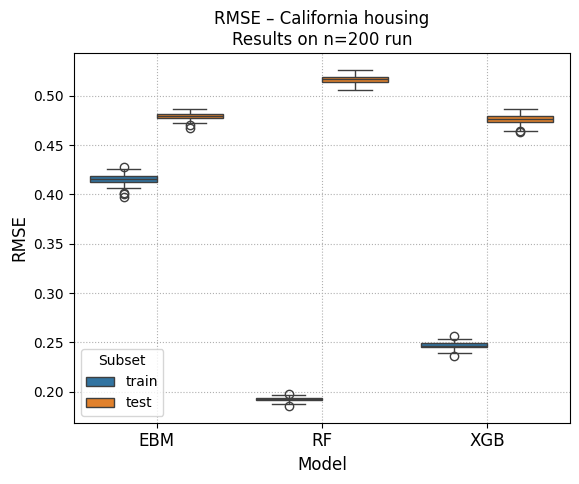

In [167]:
sns.boxplot(
    data=df_models_rmse, 
    x="model", y="model_performance", hue="subset",
    dodge=True
)

plt.xlabel("Model", fontsize=12)
plt.ylabel("RMSE", fontsize=12)

plt.legend(title="Subset")
plt.grid(linestyle=":")

plt.xticks(
    ticks=range(len(df_models_rmse["model"].unique())),
    labels=["EBM", "RF", "XGB"],
    fontsize=12
)

plt.title(f'RMSE – {choose_df.value}\nResults on n=200 run')
plt.savefig(figures_folder + f"/RMSE_{choose_df.value.lower().replace(' ', '_')}_1.pdf")
plt.show()

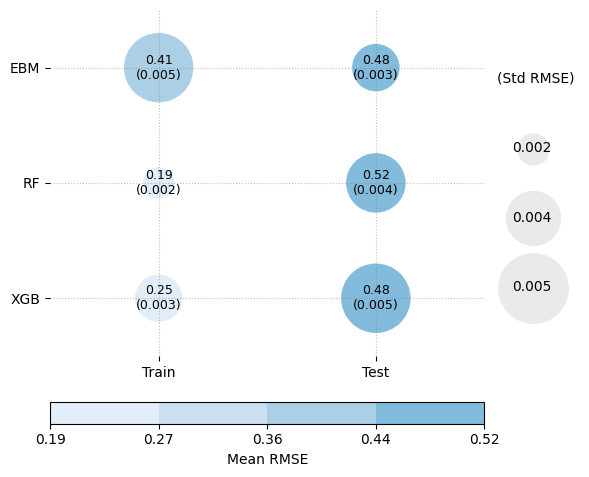

In [168]:
# Experimental viz
cmap_full = plt.get_cmap('Blues')
pastel_colors = [cmap_full(i/9) for i in range(9)][1:5]
# ListedColormap(pastel_colors)

# Pivot to have models as rows, subsets as columns
pivot_mean = df_performance_stats.pivot(index='model', columns='subset', values='mean_rmse')
pivot_std = df_performance_stats.pivot(index='model', columns='subset', values='std_rmse')

vmin = np.floor(pivot_mean.min().min() * 100) / 100
vmax = np.ceil(pivot_mean.max().max() * 100) / 100
bounds = [round(el, 2) for el in np.linspace(vmin, vmax, 5)]
colors = ['#ffcccc', '#ff9999', '#ff6666', '#ff3333']   # light → dark
cmap = ListedColormap(pastel_colors)
norm = BoundaryNorm(bounds, cmap.N)

# Create figure
fig, ax = plt.subplots(figsize=(6, 5))

# Coordinates for each point
x_labels = pivot_mean.columns
y_labels = pivot_mean.index
x = np.arange(len(x_labels))
y = np.arange(len(y_labels))

# Create a meshgrid of coordinates
xx, yy = np.meshgrid(x, y)

# Flatten data for plotting
colors = pivot_mean.to_numpy().flatten()
sizes = pivot_std.to_numpy().flatten()

# Normalize bubble sizes & invert sizes: smaller std → bigger bubble
min_size = 2500    # smallest bubble size
max_size = 500   # largest bubble size

sizes_scaled = min_size + (max_size - min_size) * (pivot_std.to_numpy().max() - sizes) / \
               (pivot_std.to_numpy().max() - pivot_std.to_numpy().min())

# Scatter plot (bubbles)
sc = ax.scatter(
        xx.flatten(), yy.flatten(),
        c=colors, s=sizes_scaled,
        cmap=cmap, norm=norm, edgecolor='none'
)

# Add text annotations
for i, model in enumerate(y_labels):
    for j, subset in enumerate(x_labels):
        mean_val = pivot_mean.loc[model, subset]
        std_val = pivot_std.loc[model, subset]
        ax.text(j, i, f"{mean_val:.2f}\n({std_val:.3f})",
                ha='center', va='center', color='black', fontsize=9)

# Format grid and labels
ax.set_xticks(x)
ax.set_xticklabels(x_labels)
ax.set_yticks(y)
ax.set_yticklabels(y_labels)
ax.grid(True, linestyle=':', color='gray', alpha=0.5)

ax.set_xlim(-0.5, len(x_labels) - 0.5)
ax.set_ylim(-0.5, len(y_labels) - 0.5)

# Reverse y-axis to have first model on top
ax.invert_xaxis()
ax.invert_yaxis()

# Remove spines for a clean look
for spine in ax.spines.values():
    spine.set_visible(False)

# Create a legend for bubble size
# Choose representative std values for the legend
std_legend_values = [pivot_std.to_numpy().min(), 
                     np.median(pivot_std.to_numpy()), 
                     pivot_std.to_numpy().max()]

# Scale these values using the same formula as the bubbles
sizes_legend = min_size + (max_size - min_size) * (pivot_std.to_numpy().max() - std_legend_values) / \
               (pivot_std.to_numpy().max() - pivot_std.to_numpy().min())

# Plot invisible points for the legend
for size, std_val in zip(sizes_legend, std_legend_values):
    ax.scatter([], [], s=size, c='#eaeaea', edgecolors=None, label=f"{std_val:.3f}")

# Add std legend
ax.legend(
    scatterpoints=1,
    frameon=False,
    labelspacing=4.0,
    handletextpad=-2.5,
    title='(Std RMSE)',
    loc='center left',
    bbox_to_anchor=(1, 0.5)
)

# Add colorbar (mean) legend 
cbar = plt.colorbar(sc, ax=ax, boundaries=bounds, ticks=bounds, orientation='horizontal', pad=0.1)
cbar.set_label('Mean RMSE')

plt.tight_layout()
# plt.savefig(f"pictures/models_results.png", dpi=600, bbox_inches="tight")
plt.savefig(figures_folder + f"/RMSE_{choose_df.value.lower().replace(' ', '_')}_2.pdf")
plt.show()

### 3.3 PIs performance

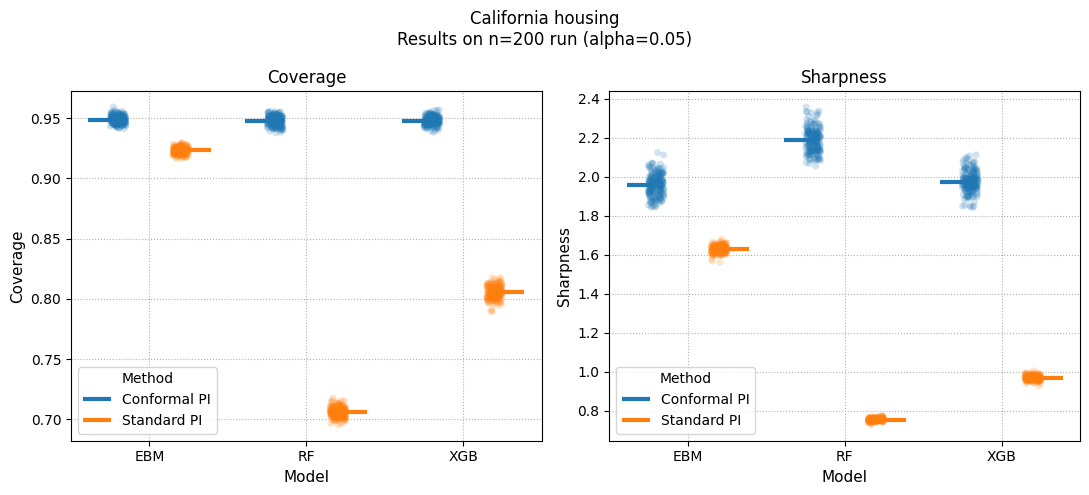

In [169]:
fig, ax = plt.subplots(1, 2, figsize=(11, 5))
sns.stripplot(
    data=df_all_results_uncertainty, 
    x="model", y="coverage", hue="metric",
    dodge=True, alpha=.2, legend=False,
    ax=ax[0]
)
sns.pointplot(
    data=df_all_results_uncertainty,
    x="model", y="coverage", hue="metric",
    dodge=.6, linestyle="none", errorbar=None,
    marker="_", markersize=20, markeredgewidth=3,
    ax=ax[0]
)
ax[0].set_title("Coverage", fontsize=12)
ax[0].set_xlabel("Model", fontsize=11)
ax[0].set_ylabel("Coverage", fontsize=11)
ax[0].grid(True, linestyle=":")
ticks = ax[0].get_xticks()
labels = [t.get_text().upper() for t in ax[0].get_xticklabels()]
ax[0].set_xticks(ticks)
ax[0].set_xticklabels(labels)
handles, _ = ax[0].get_legend_handles_labels()
labels = labels = ['Conformal PI', 'Standard PI', 'Built-in method']
ax[0].legend(
    handles, labels, title="Method",
    frameon=True
)

sns.stripplot(
    data=df_all_results_uncertainty,
    x="model", y="sharpness", hue="metric",
    dodge=True, alpha=.2, legend=False,
    ax=ax[1]
)
sns.pointplot(
    data=df_all_results_uncertainty,
    x="model", y="sharpness", hue="metric",
    dodge=.6, linestyle="none", errorbar=None,
    marker="_", markersize=20, markeredgewidth=3,
    ax=ax[1]
)
ax[1].set_title("Sharpness", fontsize=12)
ax[1].set_xlabel("Model", fontsize=11)
ax[1].set_ylabel("Sharpness", fontsize=11)
ax[1].grid(True, linestyle=":")
ticks = ax[1].get_xticks()
labels = [t.get_text().upper() for t in ax[1].get_xticklabels()]
ax[1].set_xticks(ticks)
ax[1].set_xticklabels(labels)
handles, _ = ax[1].get_legend_handles_labels()
labels = labels = ['Conformal PI', 'Standard PI', 'Built-in method']
ax[1].legend(
    handles, labels, title="Method",
    frameon=True
)

plt.suptitle(f'{choose_df.value}\nResults on n=200 run (alpha=0.05)')
plt.tight_layout()
plt.savefig(figures_folder + f"/PI_stats_{choose_df.value.lower().replace(' ', '_')}.pdf")
plt.show()

## 4. Results ebm

In [148]:
df_plot = df_all[df_all.train.isna()]
df_plot = df_plot[df_plot.model=='ebm']

In [149]:
df_ebm_results_cov = (
    df_plot
        .groupby(['df', 'metric'])
        .agg(
            mean_cov=('coverage', 'mean'),
            std_cov=('coverage', lambda x: x.std(ddof=1))
        )
        .reset_index()
)

df_ebm_results_cov['mean_cov'] = df_ebm_results_cov['mean_cov'].round(3)
df_ebm_results_cov['std_cov'] = df_ebm_results_cov['std_cov'].round(3)
df_ebm_results_cov

,df,metric,mean_cov,std_cov
0,california,built_in,0.268,0.009
1,california,conformal,0.949,0.003
2,california,standard_pi,0.923,0.003
3,diabetes,built_in,0.346,0.045
4,diabetes,conformal,0.958,0.019
5,diabetes,standard_pi,0.904,0.036


In [150]:
df_ebm_results_sharp = (
    df_plot
        .groupby(['df', 'metric'])
        .agg(
            mean_sharp=('sharpness', 'mean'),
            std_sharp=('sharpness', lambda x: x.std(ddof=1))
        )
        .reset_index()
)

df_ebm_results_sharp['mean_sharp'] = df_ebm_results_sharp['mean_sharp'].round(3)
df_ebm_results_sharp['std_sharp'] = df_ebm_results_sharp['std_sharp'].round(3)
df_ebm_results_sharp

,df,metric,mean_sharp,std_sharp
0,california,built_in,0.250,0.006
1,california,conformal,1.958,0.055
2,california,standard_pi,1.628,0.018
3,diabetes,built_in,45.574,7.112
4,diabetes,conformal,216.763,17.474
5,diabetes,standard_pi,172.281,13.316


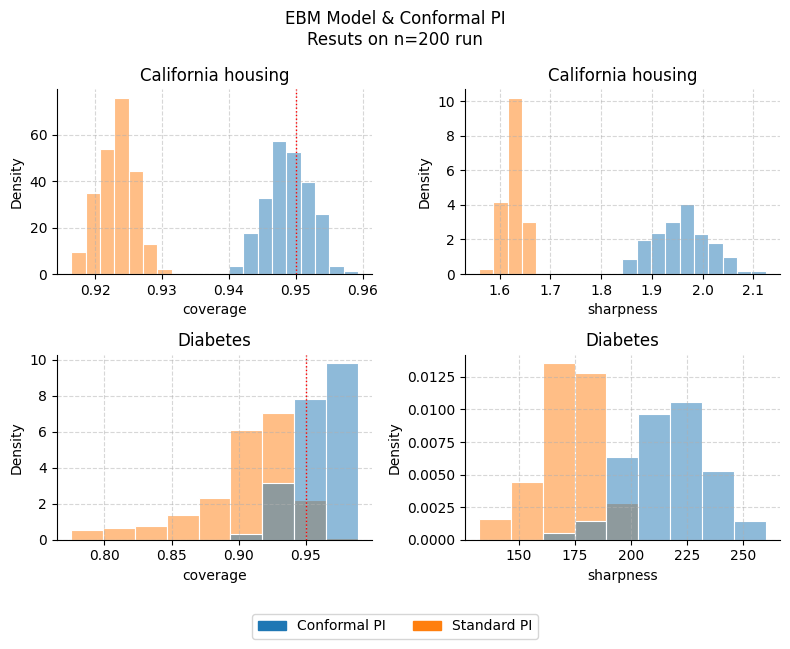

In [161]:
fig_p, ax_p = plt.subplots(2, 2, figsize=(8, 6))
ax_p = ax_p.flatten()

# Get palette
palette = plt.get_cmap('tab10')

#df_plot_cal = df_plot[(df_plot.df=='california') & (~df_plot.uncertainty_method.isin(['conformal_crepes', 'built_in']))]
df_plot_cal = df_plot[
    (df_plot.df == 'california') & 
    (~df_plot.metric.isin(['conformal_crepes', 'built_in']))
]
df_plot_diab = df_plot[
    (df_plot.df == 'diabetes') & 
    (~df_plot.metric.isin(['conformal_crepes', 'built_in']))
]

sns.histplot(
    data=df_plot_cal,
    x="coverage",
    hue="metric",
    palette="tab10",
    bins=20, 
    stat="density", 
    alpha=0.5,
    linewidth=0.8,
    edgecolor="white",
    ax=ax_p[0],
    legend=False
)
ax_p[0].axvline(x=0.95, color='red', linestyle=':', linewidth=1)
ax_p[0].grid(linestyle='--', alpha=0.5)
ax_p[0].spines['top'].set_visible(False)
ax_p[0].spines['right'].set_visible(False)
ax_p[0].set_title('California housing')

sns.histplot(
    data=df_plot_cal,
    x="sharpness",
    hue="metric",
    palette="tab10",
    bins=20, 
    stat="density", 
    alpha=0.5,
    linewidth=0.8,
    edgecolor="white",
    ax=ax_p[1],
    legend=False
)
ax_p[1].grid(linestyle='--', alpha=0.5)
ax_p[1].spines['top'].set_visible(False)
ax_p[1].spines['right'].set_visible(False)
ax_p[1].set_title('California housing')

sns.histplot(
    data=df_plot_diab,
    x="coverage",
    hue="metric",
    palette="tab10",
    bins=9, 
    stat="density", 
    alpha=0.5,
    linewidth=0.8,
    edgecolor="white",
    ax=ax_p[2],
    legend=False
)
ax_p[2].axvline(x=0.95, color='red', linestyle=':', linewidth=1)
ax_p[2].grid(linestyle='--', alpha=0.5)
ax_p[2].spines['top'].set_visible(False)
ax_p[2].spines['right'].set_visible(False)
ax_p[2].set_title('Diabetes')

sns.histplot(
    data=df_plot_diab,
    x="sharpness",
    hue="metric",
    palette="tab10",
    bins=9, 
    stat="density", 
    alpha=0.5,
    linewidth=0.8,
    edgecolor="white",
    ax=ax_p[3],
    legend=False
)
ax_p[3].grid(linestyle='--', alpha=0.5)
ax_p[3].spines['top'].set_visible(False)
ax_p[3].spines['right'].set_visible(False)
ax_p[3].set_title('Diabetes')

from matplotlib.patches import Patch

handles = [Patch(color=palette(0), label='Conformal PI'),
           Patch(color=palette(1), label='Standard PI')]

fig_p.legend(
    handles=handles,
    loc='lower center',
    ncol=2,
    frameon=True,
    bbox_to_anchor=(0.5, -0.08)
)

plt.suptitle(f"EBM Model & Conformal PI\nResuts on n=200 run")
plt.tight_layout()
plt.savefig(figures_folder + f"/EBM_PI_stats.pdf", bbox_inches="tight")
plt.show()